## What is a CNN?
A Convolutional Neural Network (CNN) is a type of deep learning model specifically designed to process structured grid data, such as images. CNNs are particularly effective for image classification, object detection, and pattern recognition tasks due to their ability to capture spatial hierarchies in the data.

## CNNs consist of multiple layers, including:

- **Convolutional Layers**: Apply filters (kernels) to the input image to extract features like edges, textures, and patterns. These layers preserve the spatial relationships in the data.
- **Pooling Layers:** Downsample the feature maps, reducing the dimensionality and computation while retaining the most important information.
- **Fully Connected Layers:** Connect every neuron in one layer to every neuron in the next layer, used towards the end of the network to make predictions based on the features extracted by the previous layers.
- **Activation Functions:** Introduce non-linearity into the network, allowing it to learn complex patterns.
## How CNN is Useful in Fire and Smoke Detection
CNNs are particularly well-suited for fire and smoke detection due to their ability to automatically learn and identify visual patterns associated with these phenomena. Here's how CNNs contribute to this task:

- **Feature Extraction:** CNNs automatically learn features such as color, texture, and shape that are characteristic of fire and smoke. These features are critical for distinguishing between fire/smoke and non-fire/smoke images.

- **Localization:** In object detection tasks, CNNs can not only classify the presence of fire or smoke but also localize it within the image, allowing for more precise detection.

- **Robustness:** CNNs are capable of learning from large datasets, which enables them to generalize well to different environments and conditions. This makes them effective in detecting fire and smoke under various lighting conditions, angles, and levels of obstruction.

- **Real-time Processing:** Due to their efficiency in processing image data, CNNs can be deployed in real-time systems, such as surveillance cameras, to detect fire and smoke immediately, enabling quicker response times in emergency situations.

- **Transfer Learning:** Pre-trained CNN models like InceptionV3, VGG16, or ResNet can be fine-tuned for fire and smoke detection, leveraging existing knowledge from other image recognition tasks, and significantly reducing the amount of data and time required for training.

              

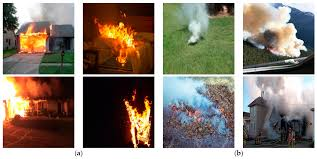

## What we cover in this Project:

1. Import Libraries

2. Load Data

3. Show Image from Numbers

4. Change Dimension / Feature Scaling

5. Build First Convolutional Neural Network

6. Train Model

7. Test & Evaluate Model

8. Transfer learning(Vgg 16)

9. Import the Vgg 16 library



In [6]:
#import libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import keras

In [7]:
keras.__version__

'3.4.1'

In [8]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Define the folder path and file name
folder_path_drive = "dataset"
file_name = "FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET.zip"

# Copy the file from Google Drive to the current working directory
!cp /content/gdrive/MyDrive/$folder_path_drive/$file_name /content/

# Change directory to /content
%cd /content

# Unzip the file
!unzip -q $file_name -d /content/Data


Mounted at /content/gdrive
/content


In [9]:
train_path = 'Data/train'
valid_path = 'Data/test'

In [ ]:
#data preprocessing

In [10]:
import tensorflow as tf
# Load the dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    label_mode='categorical',  # Change this to 'categorical' if you have more than two classes
    image_size=(150, 150),  # Adjust the size according to your needs
    batch_size=16  # Adjust the batch size as needed
)

Found 31708 files belonging to 3 classes.


In [11]:
# this is the augmentation configuration we will use for training
# It generate more images using below parameters
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

In [7]:
# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
training_data = training_datagen.flow_from_directory(train_path, # this is the target directory
                                      target_size=(150, 150), # all images will be resized to 150x150
                                      batch_size=16,
                                      class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels


Found 32398 images belonging to 3 classes.


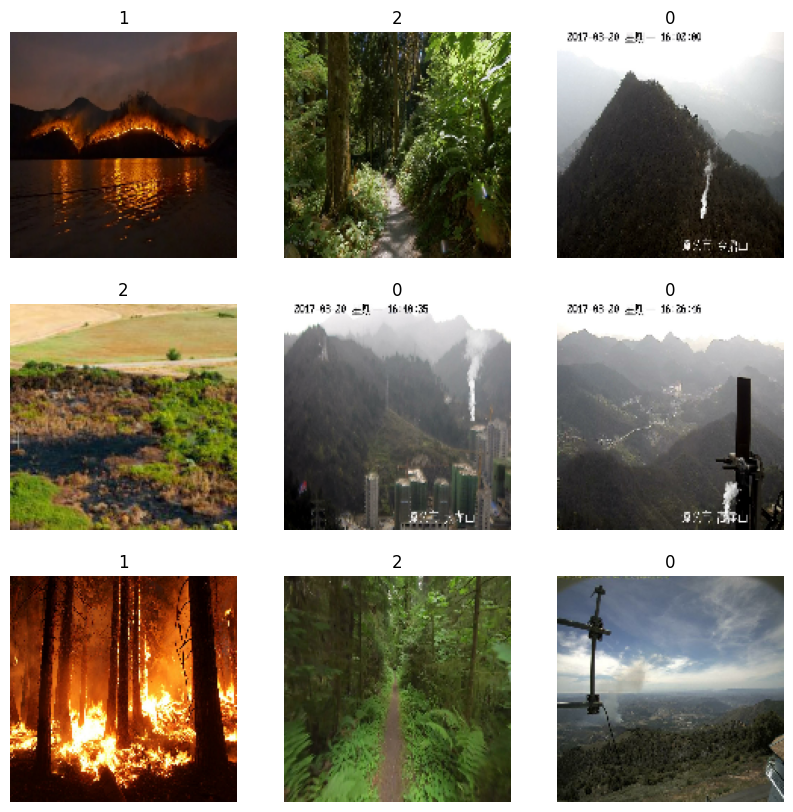

In [8]:
# Plot the first 9 images from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(tf.argmax(labels[i])))  # Convert one-hot encoded label to scalar
        plt.axis("off")

In [9]:
training_data.class_indices


{'Smoke': 0, 'fire': 1, 'non fire': 2}

In [10]:
# this is the augmentation configuration we will use for validation:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)

# this is a similar generator, for validation data
valid_data = valid_datagen.flow_from_directory(valid_path,
                                  target_size=(150,150),
                                  batch_size=16,
                                  class_mode='categorical')

Found 10500 images belonging to 3 classes.


 plotImages function, images are passed through this rescaling process before being plotted. This allows for a consistent display and further processing in machine learning pipelines.

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

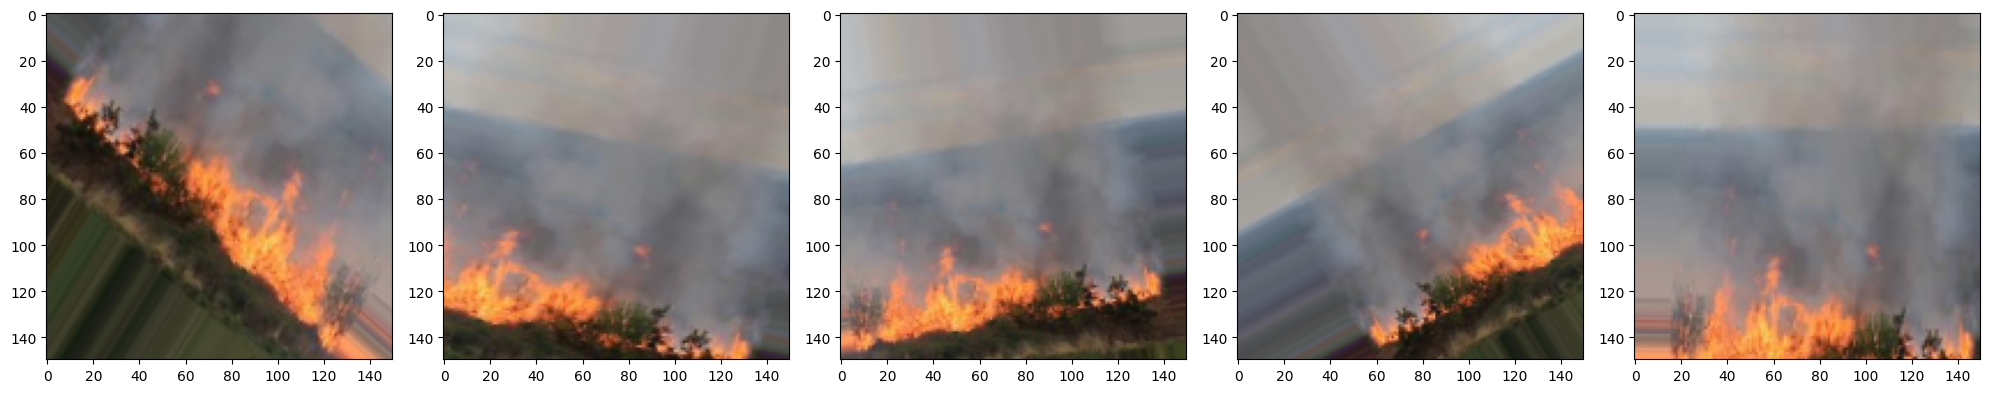

In [12]:
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

In [13]:
# Building the CNN model
cnn_model = Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, input_shape=[150, 150, 3], activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=3, activation='softmax')  # output layer
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Compile the CNN model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model_path = '/content/drive/My Drive/dataset/fire_smoke_predict.keras'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# train cnn model
history = cnn_model.fit(training_data,
                          epochs=10,
                          verbose=1,
                          validation_data= valid_data,
                          callbacks=callbacks_list) # time start 16.06

Epoch 1/10
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9146 - loss: 0.2440

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.90981, saving model to /content/drive/My Drive/dataset/fire_smoke_predict.keras
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 492s 243ms/step - accuracy: 0.9146 - loss: 0.2440 - val_accuracy: 0.9098 - val_loss: 0.2404
Epoch 2/10
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9293 - loss: 0.2068
Epoch 2: val_accuracy did not improve from 0.90981
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 482s 233ms/step - accuracy: 0.9293 - loss: 0.2068 - val_accuracy: 0.9058 - val_loss: 0.2628
Epoch 3/10
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9367 - loss: 0.1810
Epoch 3: val_accuracy improved from 0.90981 to 0.92171, saving model to /content/drive/My Drive/dataset/fire_smoke_predict.keras
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 507s 235ms/step - accuracy: 0.9367 - loss: 0.1810 - val_accuracy: 0.9217 - val_loss: 0.2277
Epoch 4/10
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9457 - loss: 0.1650
Epoch 4: val_accuracy did not improve from 0.92171
202

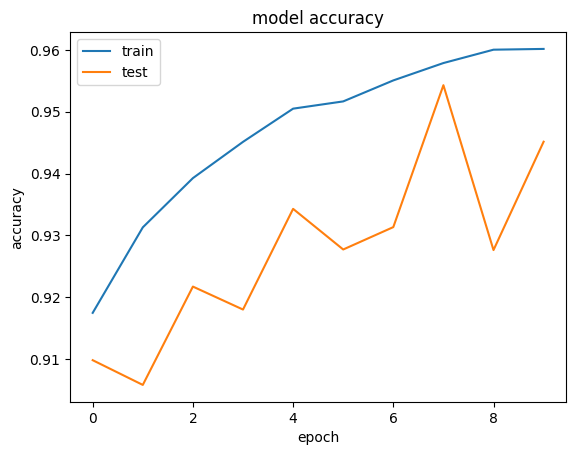

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

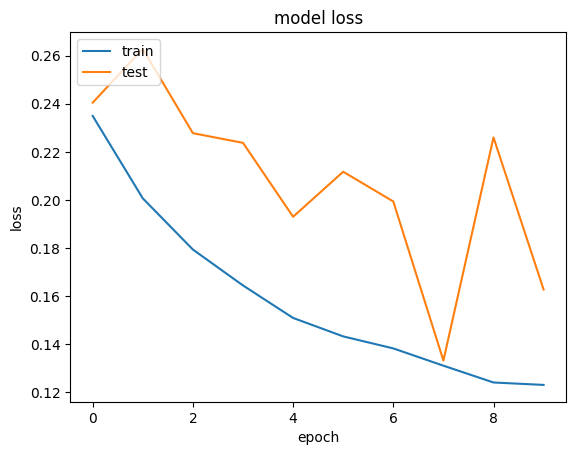

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Prediction

In [30]:
# Import Model

model_path1 = '/content/gdrive/MyDrive/dataset/fire_smoke_prediction.keras' #new model.ipynb


model1 = keras.models.load_model(model_path1)



In [31]:

"""#Preprocessing"""

#fire image path
h1 = '/content/gdrive/MyDrive/dataset/fire.jpeg'

#smoke image path

hs1 = '/content/gdrive/MyDrive/dataset/smoke.jpeg'

#non fire image path
hu1 = '/content/gdrive/MyDrive/dataset/nnfire.jpeg'




In [32]:
def fire_smoke_detection(model, fire_smoke):
    test_image = image.load_img(fire_smoke, target_size=(150, 150))
    test_image = image.img_to_array(test_image) / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    result = model.predict(test_image).round(3)

    pred = np.argmax(result)
    print(result, "--->>>", pred)

    if pred == 0:
        print('Predicted>>> smoke')
    elif pred == 1:
        print('Predicted>>> fire')
    else:
        print('Predicted>>> non fire')


In [33]:
"""## Predict Output"""

for fire_smoke in [h1,hs1,hu1]:
  fire_smoke_detection(model1,fire_smoke )


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
[[0. 1. 0.]] --->>> 1
Predicted>>> fire
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[0.513 0.013 0.474]] --->>> 0
Predicted>>> smoke
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.042 0.189 0.769]] --->>> 2
Predicted>>> non fire


In [ ]:
# Transfer Learning Method

In image classification, models like **VGG16**, **ResNet**, and **InceptionV3** are commonly used. These models have already learned a variety of low- to high-level features from millions of images, making them highly effective when fine-tuned for specific tasks, such as fire and smoke detection.

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
IMAGE_SIZE = [150, 150]
inception = InceptionV3(input_shape=IMAGE_SIZE+ [3], weights='imagenet', include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('Data/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,858,083 (83.38 MB)

 Trainable params: 55,299 (216.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
model_path = '/content/drive/My Drive/dataset/fire_smoke_predict.keras'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Data/train',
                                                 target_size = (150, 150),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 32398 images belonging to 3 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('Data/test',
                                            target_size = (150, 150),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 10500 images belonging to 3 classes.


In [ ]:
# fit the model
history = model.fit(training_set,
                          epochs=3,
                          validation_data= test_set,
                          callbacks=callbacks_list) # time start 16.06

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8887 - loss: 0.7580
Epoch 1: val_accuracy improved from -inf to 0.92867, saving model to /content/drive/My Drive/dataset/fire_smoke_predict.keras
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 585s 281ms/step - accuracy: 0.8887 - loss: 0.7580 - val_accuracy: 0.9287 - val_loss: 0.6172
Epoch 2/3
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9311 - loss: 0.7737
Epoch 2: val_accuracy did not improve from 0.92867
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 508s 250ms/step - accuracy: 0.9312 - loss: 0.7737 - val_accuracy: 0.9217 - val_loss: 0.9056
Epoch 3/3
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9432 - loss: 0.7088
Epoch 3: val_accuracy improved from 0.92867 to 0.94057, saving model to /content/drive/My Drive/dataset/fire_smoke_predict.keras
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 558s 248ms/step - accuracy: 0.9432 - loss: 0.7088 - val_accuracy: 0.9406 - val_loss: 0.7163


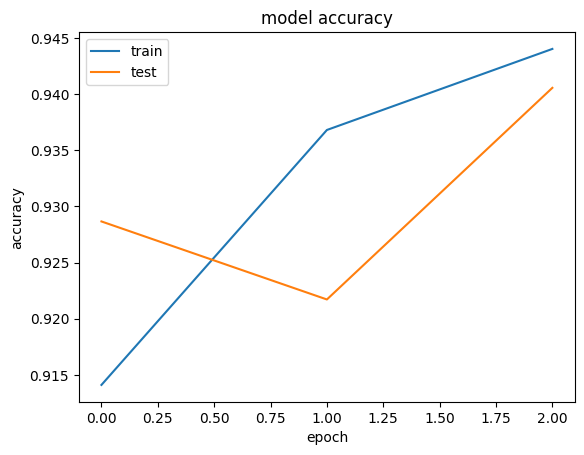

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

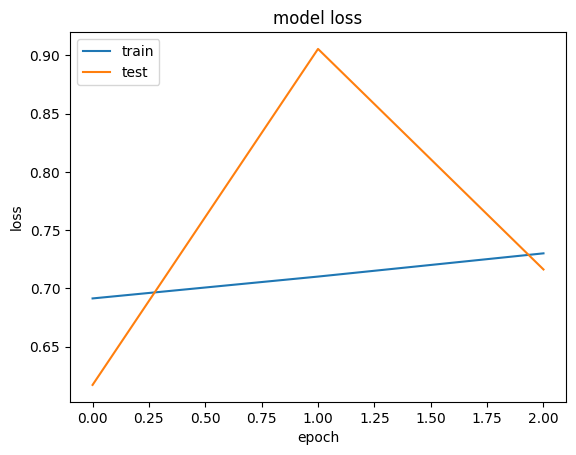

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Performance Comparison
After training both the VGG16-based model and a custom CNN for **3 epochs**, the results were as follows:

## VGG16 (Transfer Learning):

- Accuracy: 0.9432
- Loss: 0.7088
- Validation Accuracy: 0.9406
- Validation Loss: 0.7163

## Custom CNN:

- Accuracy: 0.9367
- Loss: 0.1810
- Validation Accuracy: 0.9217
- Validation Loss: 0.2277

## Comparison and Benefits
### Accuracy and Validation Performance:

The VGG16 model achieved slightly higher accuracy and validation accuracy compared to the custom CNN, indicating that the transfer learning approach was effective in recognizing fire and smoke patterns in the dataset.
However, the custom CNN had a much lower loss, which suggests that it was more confident in its predictions, especially in terms of how well it fit the training data.

## Training Efficiency:

- **VGG16**: Transfer learning allowed VGG16 to achieve high accuracy with minimal training (only 3 epochs), demonstrating the power of using pre-trained models. This is particularly useful when you have limited computational resources or a smaller dataset.
- **Custom CNN**: The custom CNN, despite being trained from scratch, performed nearly as well as VGG16. This suggests that your model was well-designed and capable of learning the features needed for fire and smoke detection effectively.
Generalization:

- **VGG16**: Since VGG16 was trained on a very large and diverse dataset (ImageNet), it may have better generalization capabilities, which is reflected in its high validation accuracy. This means it might perform better on unseen data.
- **Custom CNN**: While the custom CNN also generalizes well, its slightly lower validation accuracy could indicate a bit more overfitting compared to VGG16, though this difference is minor.

## Conclusion

### Both approaches have their strengths:

- **VGG16:** Offers quick, high-performance results with less training time, especially beneficial when dealing with limited data or computational power.
- **Custom CNN:** Provides more control over the architecture and may offer better optimization for specific tasks, though it may require more data and tuning to achieve similar or better performance compared to transfer learning models.
In our case, the choice between VGG16 and a custom CNN might depend on our specific needs: if we prioritize fast, high accuracy with minimal setup, VGG16 is advantageous. If we need a more tailored solution with potentially lower inference costs, our custom CNN might be preferable.